In [1]:
import pickle

filenames = [
             'Gummy Worm Dataset__SVM__Samples_10000__Estimators_132__Folds_5__AbsoluteValues__20250331_182934.pkl',
             'Gummy Worm Dataset__Neural Network__Samples_10000__Estimators_128__Folds_5__AbsoluteValues__20250331_182934.pkl', 
             'Gummy Worm Dataset__Logistic Regression__Samples_10000__Estimators_168__Folds_5__AbsoluteValues__20250331_182934.pkl',
             'Gummy Worm Dataset__Random Forest__Samples_10000__Estimators_144__Folds_5__AbsoluteValues__20250331_182934.pkl',
             #'Exclamation Mark Dataset__SVM__Samples_10000__Estimators_132__Folds_5__AbsoluteValues__20250513_204432.pkl',
             #'Exclamation Mark Dataset__Neural Network__Samples_10000__Estimators_128__Folds_5__AbsoluteValues__20250513_204432.pkl',
             #'Exclamation Mark Dataset__Logistic Regression__Samples_10000__Estimators_168__Folds_5__AbsoluteValues__20250513_204432.pkl',
             #'Exclamation Mark Dataset__Random Forest__Samples_10000__Estimators_144__Folds_5__AbsoluteValues__20250513_204432.pkl'
         ]

resultss = []
models = ["SVM", "Neural Network", "Logistic Regression", "Random Forest"]
for filename in filenames:
    with (open(f'../grid_search/data/{filename}', 'rb') as file):
        resultss.append(pickle.load(file))

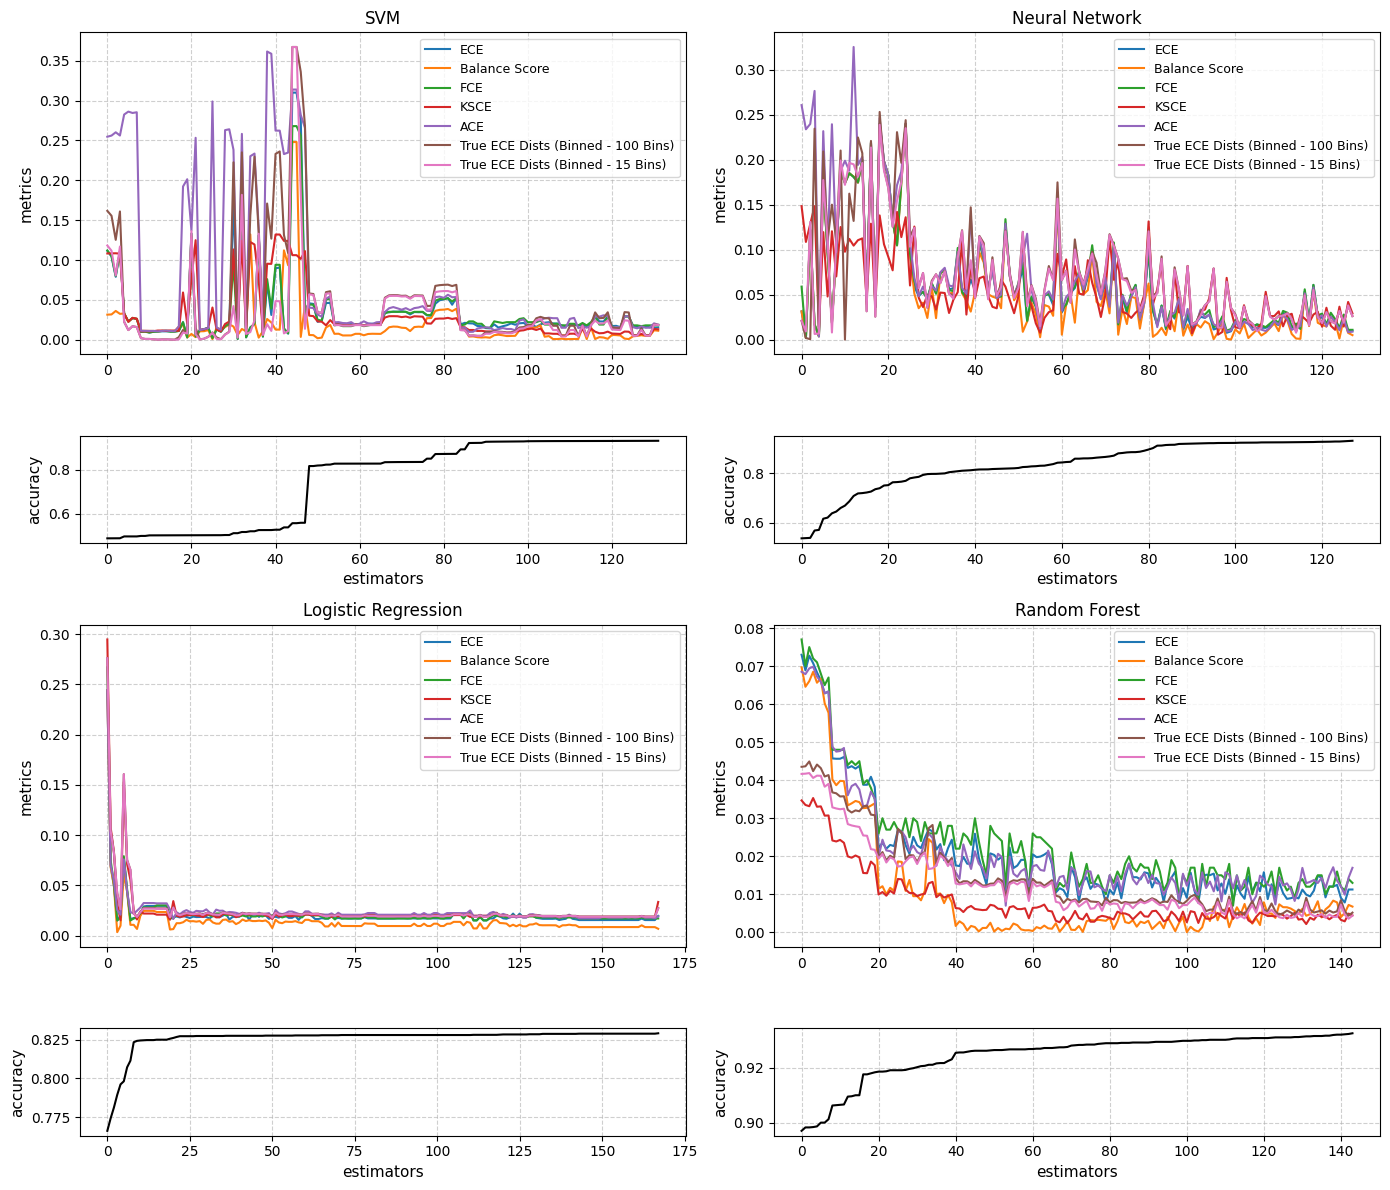

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(14, 12))
gs = GridSpec(4, 2, height_ratios=[3, 1, 3, 1], figure=fig)

for i, results in enumerate(resultss):
    col = i % 2
    base_row = 0 if i < 2 else 2

    # Plot calibration metrics
    ax = fig.add_subplot(gs[base_row, col])
    ax.set_title(models[i], fontsize=12)
    ax.set_ylabel("metrics", fontsize=11)
    ax.grid(True, linestyle='--', alpha=0.6)

    accuracies = np.array([result["Accuracy"] for result in results])
    indices = np.argsort(accuracies)

    valuess = [list(result.values()) for result in results]
    metrics = np.array(valuess).T
    x_values = range(len(results))
    metric_names = list(results[0].keys())

    for j, metric in enumerate(metrics):
        metric_name = metric_names[j]
        if metric_name not in ["TCE", "Accuracy", "True ECE Grid (Binned - 100 Bins)", "True ECE Grid (Binned - 15 Bins)"]:
            ax.plot(x_values, metric[indices], label=metric_name)
    ax.legend(fontsize=9)
    
    # Plot accuracy below
    ax_acc = fig.add_subplot(gs[base_row + 1, col])
    ax_acc.plot(x_values, accuracies[indices], color='black')
    ax_acc.set_xlabel("estimators", fontsize=11)
    ax_acc.set_ylabel("accuracy", fontsize=11)
    ax_acc.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout() 
#plt.savefig("./plots/grid_search_summary_gummy_worm")
#plt.savefig("./plots/grid_search_summary_exclamation_mark")
plt.show()


In [34]:
from sklearn.metrics import mean_absolute_error

df_list = []

for i, results in enumerate(resultss):
    model = models[i]
    
    true_eces = np.array([result["True ECE Grid (Binned - 15 Bins)"] for result in results])
    eces = np.array([result["ECE"] for result in results])
    fces = np.array([result["FCE"] for result in results])
    aces = np.array([result["ACE"] for result in results])
    tces = np.array([result["TCE"] for result in results])
    ksces = np.array([result["KSCE"] for result in results])
    balance_scores = np.array([result["Balance Score"] for result in results])
    
    df_list.append({
        "model": model,
        "ECE": mean_absolute_error(eces, true_eces),
        "FCE": mean_absolute_error(fces, true_eces),
        "ACE": mean_absolute_error(aces, true_eces),
        "TCE": mean_absolute_error(tces, true_eces),
        "KSCE": mean_absolute_error(ksces, true_eces),
        "Balance Score": mean_absolute_error(balance_scores, true_eces),
    })

In [35]:
import pandas as pd

pd.set_option('display.max_columns', None)
df = pd.DataFrame(df_list)
print(df)

                 model       ECE       FCE       ACE       TCE      KSCE  \
0                  SVM  0.165515  0.164530  0.140810  0.267408  0.164387   
1       Neural Network  0.058993  0.057587  0.060089  0.398549  0.067344   
2  Logistic Regression  0.198447  0.197547  0.195249  0.089659  0.195534   
3        Random Forest  0.017539  0.015662  0.017171  0.327356  0.024972   

   Balance Score  
0       0.180097  
1       0.065105  
2       0.204892  
3       0.025886  


In [36]:
model_names = df["model"]
data_only = df.drop(columns=["model"])

def highlight_row(row):
    ranks = row.rank(method="min", ascending=True)
    formatted = row.astype(str)

    for col in row.index:
        val = row[col]
        if ranks[col] == 1:
            formatted[col] = f"\\textbf{{{val:.5f}}}"
        elif ranks[col] == 2:
            formatted[col] = f"\\underline{{{val:.5f}}}"
        else:
            formatted[col] = f"{val:.5f}"
    return formatted

# Apply formatting row-wise
styled_data = data_only.apply(highlight_row, axis=1)

# Add back the model column
styled_df = pd.concat([model_names, styled_data], axis=1)

latex_code = styled_df.to_latex(index=False, caption="Mean absolute error between True ECE$_{grid}^{15]$ and various metrics")
print(latex_code)

\begin{table}
\caption{Mean absolute error between True ECE$_grid^15$ and various metrics}
\begin{tabular}{lllllll}
\toprule
model & ECE & FCE & ACE & TCE & KSCE & Balance Score \\
\midrule
SVM & 0.16551 & 0.16453 & \textbf{0.14081} & 0.26741 & \underline{0.16439} & 0.18010 \\
Neural Network & \underline{0.05899} & \textbf{0.05759} & 0.06009 & 0.39855 & 0.06734 & 0.06511 \\
Logistic Regression & 0.19845 & 0.19755 & \underline{0.19525} & \textbf{0.08966} & 0.19553 & 0.20489 \\
Random Forest & 0.01754 & \textbf{0.01566} & \underline{0.01717} & 0.32736 & 0.02497 & 0.02589 \\
\bottomrule
\end{tabular}
\end{table}
